In [1]:
import pandas as pd
import numpy as np
import parameters as P
import sensitivity_parameters as SP
import helper_functions as hf

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
io_data = pd.read_csv(P.io_table_dollars_water_path)
cost = hf.csv_dict_list(P.cost_impact_water_path)
water_consumption = hf.csv_dict_list(P.water_consumption_path) 
water_withdrawal = hf.csv_dict_list(P.water_withdrawal_path) 
etoh_feed_stream_mass_kg = 1 

In [4]:
y = {}
for item in cost.keys():
    y.update({item:0})

In [5]:
m = {} 
for scenario in P.scenario_range:
    new_data = np.zeros([7,3])
    m[scenario] = pd.DataFrame(new_data, columns=P.selectivity, index=P.processes)

In [6]:
for selectivity in P.selectivity:
    for scenario in P.scenario_range:
        y["lysine.us.kg"] = cost["lysine.us.kg"] * (SP.other_params[selectivity]['chlys_amount'][scenario] * 
                            SP.common_params['chlys_percent'][scenario]) 
        # 58% lysine + 42% ChOH for Chylys production (Stoichiometry) 
        y["cholinium.hydroxide.kg"] = (cost["cholinium.hydroxide.kg"] * 
                                       SP.other_params[selectivity]['chlys_amount'][scenario] * 
                                       SP.common_params['cholinium_percent'][scenario])  
        # 58% lysine + 42% ChOH for Chylys production (Stoichiometry) 
        y["cellulase.kg"] = cost["cellulase.kg"] * SP.common_params['enzyme'][scenario]
        y["csl.kg"] = cost["csl.kg"] * SP.other_params[selectivity]['csl.kg'][scenario]
        y["farmedstover.kg"] = cost["farmedstover.kg"] * SP.other_params[selectivity]['feedstock'][scenario]  
        y["dap.kg"] = cost["dap.kg"] * SP.other_params[selectivity]['dap.kg'][scenario] 
        y["h2so4.kg"] = cost["h2so4.kg"] * SP.other_params[selectivity]['h2so4.kg'][scenario]
        y["naturalgas.MJ"] = cost["naturalgas.MJ"] * (hf.FuelConvertMJ(
                            SP.other_params[selectivity]['ng_input_stream_mass_ww_kg'][scenario], "naturalgas","kg"))
        y["rail.mt_km"] = (cost["rail.mt_km"] * (SP.other_params[selectivity]['chlys_amount'][scenario]/1000) * 
                        SP.common_params['chlys_rail_mt_km'][scenario] +
                            cost["rail.mt_km"] * (
                                etoh_feed_stream_mass_kg/1000 * SP.common_params['etoh_distribution_rail'][scenario])) 
        y["flatbedtruck.mt_km"] = (cost["flatbedtruck.mt_km"] * (
                (SP.other_params[selectivity]['chlys_amount'][scenario]/1000) * 
                    SP.common_params['chlys_flatbedtruck_mt_km'][scenario]) +
                        cost["flatbedtruck.mt_km"] * (etoh_feed_stream_mass_kg/1000 * (
                            SP.common_params['etoh_distribution_truck'][scenario])))
        y["electricity.{}.kWh".format(SP.analysis_params['facility_electricity'])] = (
            cost["electricity.{}.kWh".format(SP.analysis_params['facility_electricity'])] * (
                SP.other_params[selectivity]['electricity_requirements'][scenario]))
        y["hcl.kg"] = cost["hcl.kg"] * SP.other_params[selectivity]['hcl.kg'][scenario]

        biorefinery_direct_ghg = hf.FuelCO2kg(hf.FuelConvertMJ(
                SP.other_params[selectivity]['ng_input_stream_mass_ww_kg'][scenario],"naturalgas","kg"), "naturalgas")

        results_kg_co2e = hf.TotalWaterConsumption(io_data, y, cost, 
                                water_consumption, SP.other_params[selectivity]['biorefinery_direct_consumption'][scenario])
        
        results_kg_co2e_dict = results_kg_co2e.set_index('products')['liter_results_kg'].to_dict()

        hf.AggregateResults(m, results_kg_co2e_dict, selectivity, scenario)
        
        m[scenario][selectivity] = m[scenario][selectivity] /27 # converting kg per kg results to g per MJ

In [7]:
m['avg']

,iHG-Projected,iHG-Current,waterwash
Farming,0.000000,0.000000,0.000000
Transportation,0.000000,0.000000,0.000000
Petroleum,0.034296,0.046199,0.067088
Electricity,0.027498,0.068971,0.172413
Chemicals_And_Fertilizers,0.040954,0.090594,0.066985
Direct,0.237037,0.237037,0.048148
Other,0.000259,0.001370,0.001481


In [19]:
aggregated_data_avg = m['avg'][['waterwash', 'iHG-Current', 'iHG-Projected']].T
aggregated_data_low = m['low'][['waterwash', 'iHG-Current', 'iHG-Projected']].T
aggregated_data_high = m['high'][['waterwash', 'iHG-Current', 'iHG-Projected']].T

In [20]:
aggregated_data_avg['electricity_credit'] = [0, -0.006, -0.08]
aggregated_data_low['electricity_credit'] = [0, -0.009, -0.09]
aggregated_data_high['electricity_credit'] = [0, -0.005, -0.06]

In [21]:
aggregated_data_avg_pos = aggregated_data_avg.drop(['electricity_credit'],1)
aggregated_data_low_pos = aggregated_data_low.drop(['electricity_credit'],1)
aggregated_data_high_pos = aggregated_data_high.drop(['electricity_credit'],1)

In [22]:
aggregated_data_avg_plot = aggregated_data_avg[list(reversed(aggregated_data_avg.columns.values))]

In [23]:
aggregated_data_avg_plot

,electricity_credit,Other,Direct,Chemicals_And_Fertilizers,Electricity,Petroleum,Transportation,Farming
waterwash,0.000,0.001481,0.048148,0.066985,0.172413,0.067088,0,0
iHG-Current,-0.006,0.001370,0.237037,0.090594,0.068971,0.046199,0,0
iHG-Projected,-0.080,0.000259,0.237037,0.040954,0.027498,0.034296,0,0


In [24]:
error_min = (aggregated_data_low.sum(axis=1) - aggregated_data_avg_pos.sum(axis=1)).values*(-1)
error_max = (aggregated_data_high.sum(axis=1) - aggregated_data_avg_pos.sum(axis=1)).values
plt_errors = [error_min, error_max]

In [25]:
import mpld3
#mpld3.enable_notebook()
mpld3.disable_notebook()

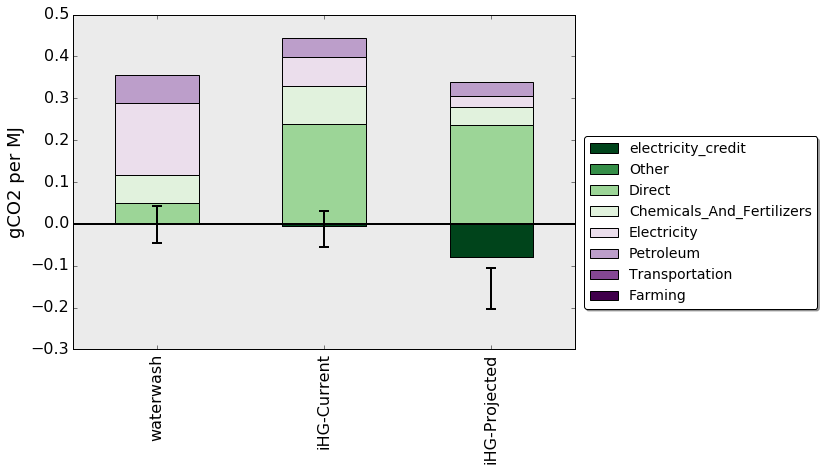

In [26]:

plot = aggregated_data_avg_plot.plot(kind='bar', stacked = True, figsize=(9,6),
                                     colormap='PRGn_r',
                                     yerr={'Farming':plt_errors}, 
                                     error_kw= {'capsize':5, 'ecolor':'k', 'elinewidth':2, 'capthick':2, 'barsabove':True})
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.ylabel('gCO2 per MJ', fontsize = 18)
#plt.ylim(-20,195)
plt.axhline(0, color='black', linewidth=2)
plot.set_axis_bgcolor("#EBEBEB")
plot.legend(loc='lower center', bbox_to_anchor=(1.25, 0.1),ncol=1, fancybox=True, shadow=True,fontsize=14)

In [ ]:
hcl
coal
diesel

In [ ]:
mpld3.fig_to_html(plt.gcf())

In [ ]:
cost['hcl.kg']